In [1]:
import glob
import os.path

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


from sklearn import datasets, linear_model, ensemble, neural_network
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

In [2]:
# Use this for larger plots:
#matplotlib.rc('figure', figsize=(15, 10))
matplotlib.rc('figure', figsize=(10, 8))

<div style="text-align:center">
<h1>xarray</h1>

<br><br>
<img src="xarray-logo.png" style="width: 50%; margin: auto;">
</div>

In [3]:
COUNTRIES = 'Austria', 'Germany', 'Switzerland', 'Italy', 'Spain', 'Sweden', 'United Kingdom'

# From previous lecture...

In [4]:
CONFIG_FILE = '../entsoe-data.config'

if not os.path.exists(CONFIG_FILE):
    download_dir = input('Path to ENTSO-E data folder: ')
    if not os.path.isdir(download_dir):
        raise RuntimeError(f'Invalid download_dir, please run cell again: {download_dir}')
    with open(CONFIG_FILE, 'w') as f:
        f.write(download_dir)
else:
    with open(CONFIG_FILE) as f:
        download_dir = f.read()
        
# Clear the output after this cell if you want to aovid having your path in the notebook (or execute it twice)!

In [5]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    
    print("Files read, concatenating to dataframe...")
    data = pd.concat(each_csv_file, ignore_index=True)
    
    print("Sorting and indexing...")
    data = data.set_index("DateTime")
    data.sort_index(inplace=True)
    
    # filter only for countries under consideration to make things faster and consume less RAM...
    data_ = data[data.AreaName.isin(COUNTRIES)].copy()
    del data
    data = data_
    
    print("Resampling...")
    data = data.groupby('AreaName').resample("1h").mean()
    
    # we should end up with a dataframe with DateTime as index, AreaName as columns
    # and Total load as entries...
    print("Reshaping dataframe...")
    data = data.TotalLoadValue.unstack(level=0).interpolate()
    
    print("Loading done.")

    return data


# note: this might require 3GB of RAM

power_demand = load_complete_entso_e_data(download_dir)

Concatenating 69 csv files...
Files read, concatenating to dataframe...
Sorting and indexing...
Resampling...
Reshaping dataframe...
Loading done.


# Erratum: there was a mistakes last time

Random split cannot be used on time series to determine quality of fit, in particular overfitting.

<img src="overfitting.png" width="40%">

<small>Source: <a href="https://en.wikipedia.org/wiki/File:Overfitting.svg">Chabacano</a> CC-BY-SA 4.0</small>

In [6]:
def f(x):
    return np.cos(x * 2 * np.pi)

X = np.linspace(0, 3, num=100)[:, np.newaxis]
Y = f(X)[:, 0]

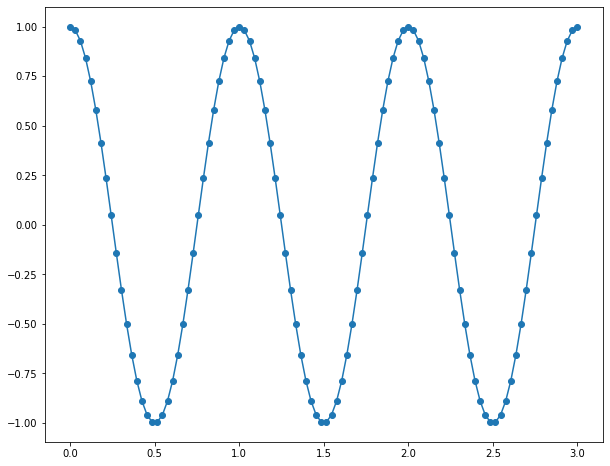

In [7]:
plt.plot(X[:, 0], Y, 'o-')

In [8]:
forest = ensemble.RandomForestRegressor()
forest.fit(X, Y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [9]:
forest.score(X, Y)

0.9984933278951602

Ok, we got a good score on our training data!

Let's generate some new (unseen) samples for `X` and use them as test data!

In [10]:
X_test_inbetween = np.linspace(1, 3, num=20)[:, np.newaxis]
X_test_after = np.linspace(3, 5, num=20)[:, np.newaxis]

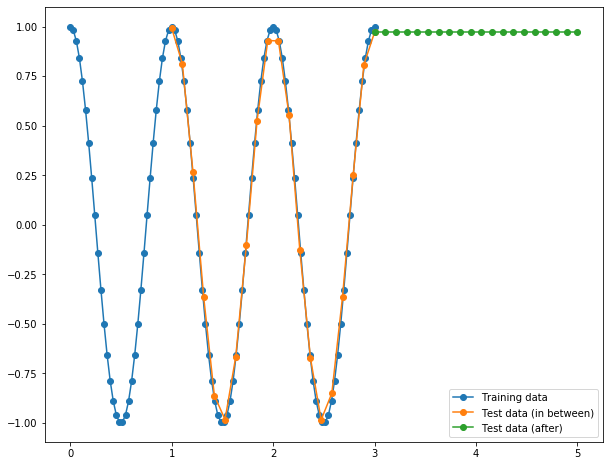

In [11]:
plt.plot(X[:, 0], Y, 'o-', label='Training data')
plt.plot(X_test_inbetween[:, 0],
         forest.predict(X_test_inbetween),
         'o-', label='Test data (in between)')

plt.plot(X_test_after[:, 0],
         forest.predict(X_test_after),
         'o-', label='Test data (after)')

plt.legend()

Both tests sets contain only unseen values, but the performance is way worse on the `X_test_after`. The forest learned only to calculate `f()` between 0 and 3 and can't predict values above 3.

**Mistake from last time:**

In our case, splitting data randomly into test/training was a very bad choice, because we measured the score on `X_in_between` (random samples between 2015 and 2019) but we are probably interested in a score on `X_after` (training 2015-2018, test 2019).

Let's now train a different forest - this time a bit more similar to what we did last week. We will assume 

In [12]:
# just train on fraction of the period, i.e. just use decimals after the comma
X_fraction = np.modf(X)[0]

forest_periodic = ensemble.RandomForestRegressor()
forest_periodic.fit(X_fraction, Y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

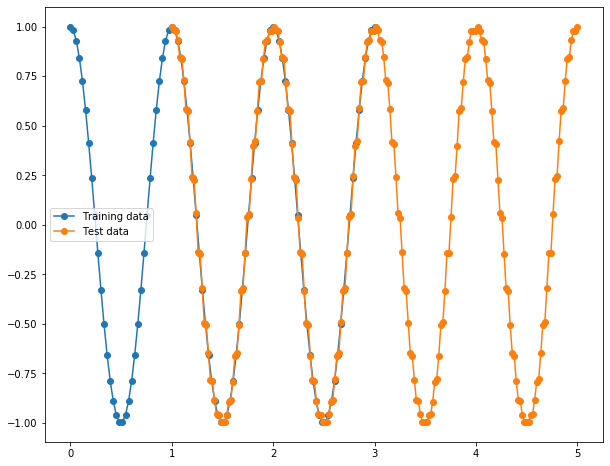

In [13]:
x = np.linspace(1, 5, num=200)
X_fraction_test = np.modf(x)[0][:, np.newaxis]

plt.plot(X[:, 0], Y, 'o-', label='Training data')
plt.plot(x, forest_periodic.predict(X_fraction_test), 'o-', label='Test data')
plt.legend()

If there is noise or a trend in the data, it doesn't work that well, but still good enough.That means our forest wasn't performing too bad, but way worse than we thought it did.

# The easy way: plot relative power demand by aggregating weekly

In [14]:
power_demand_normal = power_demand['2015-01-01':'2019-12-31']
power_demand_covid = power_demand['2020-01-01':'2020-12-31']

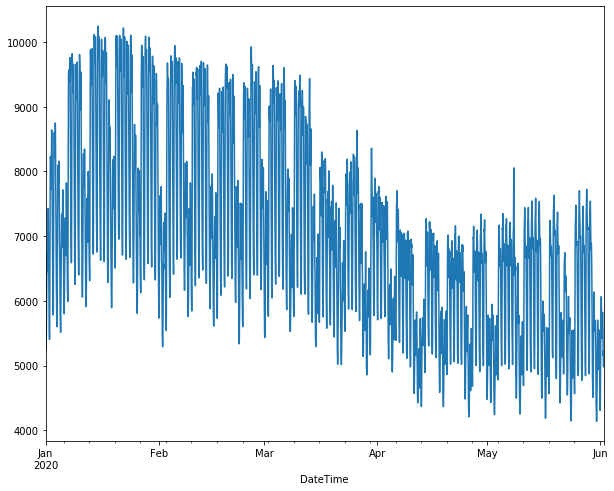

In [15]:
power_demand_covid.Austria.plot()

In [16]:
power_demand_normal_weekly = power_demand_normal.groupby(power_demand_normal.index.week).mean()[1:-1]
power_demand_covid_weekly = power_demand_covid.groupby(power_demand_covid.index.week).mean()[1:-1]

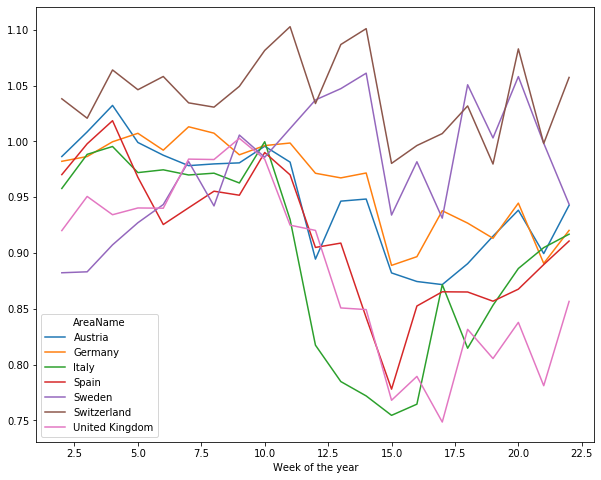

In [17]:
(power_demand_covid_weekly / power_demand_normal_weekly).plot()
plt.xlabel('Week of the year');

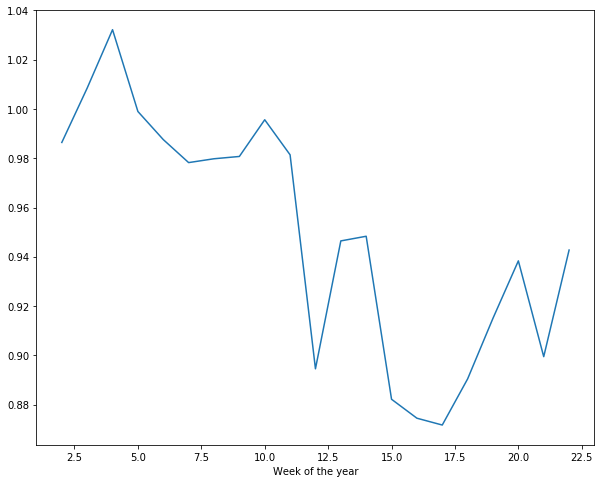

In [18]:
(power_demand_covid_weekly.Austria / power_demand_normal_weekly.Austria).plot()
plt.xlabel('Week of the year');

# Temperature data

ERA5 data is provided as NetCDF file. The library `xarray` comes in very handy to load such files.

In [19]:
import xarray as xr

In [20]:
temperatures_dataset = xr.load_dataset('../data/temperatures_era5.nc')

In [21]:
temperatures_dataset

<xarray.Dataset>
Dimensions:    (latitude: 70, longitude: 77, time: 46009)
Coordinates:
  * longitude  (longitude) float32 -13.5 -13.0 -12.5 -12.0 ... 23.5 24.0 24.5
  * latitude   (latitude) float32 70.0 69.5 69.0 68.5 ... 37.0 36.5 36.0 35.5
  * time       (time) datetime64[ns] 2015-01-01 ... 2020-04-01
Data variables:
    t2m        (time, latitude, longitude) float32 nan nan nan ... 285.54413 nan
Attributes:
    Conventions:  CF-1.6
    history:      2020-06-01 12:39:22 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [22]:
temperatures = temperatures_dataset.t2m

In [23]:
temperatures

<xarray.DataArray 't2m' (time: 46009, latitude: 70, longitude: 77)>
array([[[      nan,       nan,       nan, ..., 271.84814, 270.50635,
         269.94232],
        [      nan,       nan,       nan, ..., 272.182  , 271.88733,
         271.63693],
        [      nan,       nan,       nan, ..., 271.85825, 271.62936,
         271.83676],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan, 281.32657,
               nan]],

       [[      nan,       nan,       nan, ..., 271.8418 , 270.56958,
         270.0751 ],
        [      nan,       nan,       nan, ..., 272.16302, 271.9354 ,
         271.6496 ],
        [      nan,       nan,       nan, ..., 272.12256, 271.77478,
         271.87216],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan, 281.20264,
               nan]],

       [[      nan,       nan,       nan, ..., 271.81778, 270.62778,
         270.09662],
        [      nan,       nan,       nan, ..., 272.22372, 272.0214 ,
         271.60278],
        [      nan,       nan,       nan, ..., 272.5892 , 272.1668 ,
         272.08716],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan, 281.09766,
               nan]],

       ...,

       [[      nan,       nan,       nan, ..., 266.33685, 264.79526,
         264.29193],
        [      nan,       nan,       nan, ..., 265.28848, 265.32516,
         265.45035],
        [      nan,       nan,       nan, ..., 265.5591 , 265.27835,
         265.45035],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan, 285.73886,
               nan]],

       [[      nan,       nan,       nan, ..., 266.17374, 264.61948,
         264.28183],
        [      nan,       nan,       nan, ..., 265.11902, 265.20123,
         265.40228],
        [      nan,       nan,       nan, ..., 265.4124 , 265.21133,
         265.41113],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan, 285.67438,
               nan]],

       [[      nan,       nan,       nan, ..., 265.7526 , 263.57236,
         263.5471 ],
        [      nan,       nan,       nan, ..., 264.9015 , 264.87747,
         265.03555],
        [      nan,       nan,       nan, ..., 265.23285, 265.009  ,
         265.20248],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan, 285.54413,
               nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -13.5 -13.0 -12.5 -12.0 ... 23.5 24.0 24.5
  * latitude   (latitude) float32 70.0 69.5 69.0 68.5 ... 37.0 36.5 36.0 35.5
  * time       (time) datetime64[ns] 2015-01-01 ... 2020-04-01
Attributes:
    units:      K
    long_name:  2 metre temperature

Oh there are NaN values? How many of them?

In [24]:
total_size = temperatures.sizes['time'] * temperatures.sizes['latitude'] * temperatures.sizes['longitude']
float(np.isnan(temperatures).sum() / total_size)

0.5575139146567718

Uh 55% of missing values.. That's not good! What could that be?

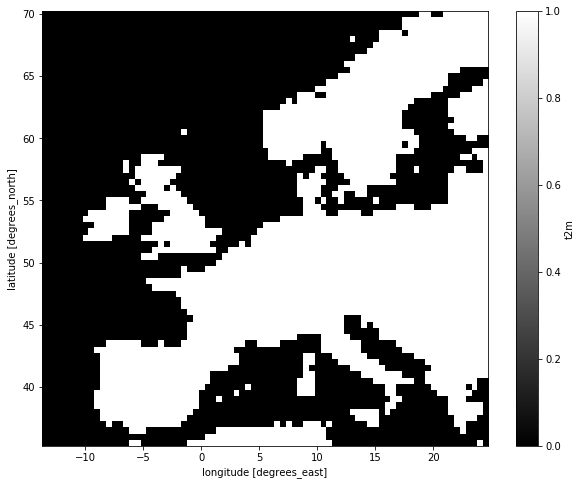

In [25]:
(~np.isnan(temperatures)).prod(dim='time').plot.imshow(cmap='gray')

**Note:** We downloaded the product `'reanalysis-era5-land'`, there is also `'era5-single-levels'` which contains data also for locations in the sea.

# Exercise 1

Plot the mean temperature for each location!

(There will be a warning because of the NaNs, but that's okay.)

Temperature seems not to be in °C...

In [27]:
temperatures = temperatures - 273.15
temperatures.name = 'Temperature [C°]'

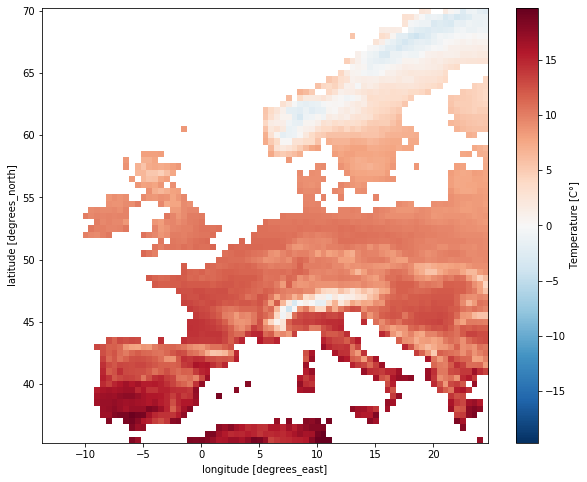

In [28]:
temperatures.mean(dim='time').plot.imshow()

# Pick random grid points to calculate the mean

As a next step, we want to calculate the mean temperature for each country.

We'll pick just some random samples from the grid for each country, to make computation of the man faster. The coordinates are already prepared as CSV file, which has been generated using the following code.

In [29]:
def choose_country_points(longitude, latitude, grid_points_per_country=200):
    """Pick random points for each country from the grid with axis ``longitude`` and ``latitude``.
    ``size`` is the number of points ot be picked for 
    
    Returns a dataframe with two columns per country (longitude & latitude)
    and ``grid_points_per_country`` numbers of rows.
    
    Note: GeoJSON always uses WGS84:
    https://tools.ietf.org/html/rfc7946
    
    """
    # local import to avoid dependency
    import geopandas
    from shapely.geometry import Point
    
    longitudes, latitudes = np.meshgrid(longitude, latitude)
    
    longitudes = longitudes.flatten()
    latitudes = latitudes.flatten()
    
    grid_points = geopandas.GeoSeries(geopandas.points_from_xy(longitudes.flatten(),
                                                           latitudes.flatten()))
    
    # XXX fix me, correct path!
    country_borders = geopandas.read_file('../data/countries.geojson')

    chosen_gridpoints = pd.DataFrame()

    for country in COUNTRIES:
        print(f"Picking grid points for {country}...")
        is_country = country_borders.ADMIN == country

        country_border = country_borders[is_country].geometry.iloc[0]

        is_in_country = grid_points.within(country_border)

        number_of_points = is_in_country.sum()
        
        # make things reproducible!
        np.random.seed(42)
        
        idcs = np.random.randint(number_of_points, size=grid_points_per_country)

        chosen_gridpoints[f'{country}_longitude'] = longitudes[is_in_country][idcs]
        chosen_gridpoints[f'{country}_latitude'] = latitudes[is_in_country][idcs]
        
    return chosen_gridpoints

In order to recreate the `country_points.csv` one needs to install `geopandas` and download a `GeoJSON` file (23MB) which contains the country borders. On windows there might be no `wget` command, use `requests.get()` instead to download the file:

In [30]:
# !conda install --yes geopandas
# !wget -O ../data/countries.geojson https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson

The following lines create the `country_points.csv`:

In [31]:
# country_points = choose_country_points(temperatures.longitude, temperatures.latitude)
# country_points.to_csv('../data/country_points.csv', index=False)

But since it is already prepared, let's just load it...

In [32]:
country_points = pd.read_csv('../data/country_points.csv')

In [33]:
country_points

,Austria_longitude,Austria_latitude,Germany_longitude,Germany_latitude,Switzerland_longitude,Switzerland_latitude,Italy_longitude,Italy_latitude,Spain_longitude,Spain_latitude,Sweden_longitude,Sweden_latitude,United Kingdom_longitude,United Kingdom_latitude
0,15.5,47.0,13.5,51.0,7.5,47.0,15.0,40.5,-4.0,40.5,16.0,65.0,-4.5,52.0
1,10.0,47.0,8.5,51.0,7.0,46.0,14.0,41.0,-3.0,38.0,12.0,58.0,-2.5,52.5
2,16.0,48.0,9.5,53.5,8.0,46.5,11.5,46.0,-1.5,41.0,18.0,65.0,-4.0,57.5
3,16.5,48.5,7.5,50.5,9.5,47.0,17.5,40.5,-5.0,43.0,17.5,66.0,-2.5,52.0
4,12.5,47.5,7.0,51.5,8.0,47.0,11.5,42.5,-2.0,40.5,16.0,62.0,-1.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,15.5,48.5,10.0,49.0,8.0,47.5,10.5,45.0,-4.5,37.5,21.0,65.5,0.5,52.5
196,11.5,47.0,10.0,50.0,7.5,46.0,8.0,46.0,-2.5,40.0,16.0,61.5,-6.0,55.0
197,14.5,48.5,12.0,50.0,6.5,46.5,17.0,41.0,-5.0,40.0,14.5,59.5,0.0,51.0
198,14.0,48.0,14.0,52.5,7.0,47.0,10.5,44.5,-2.5,37.0,20.5,64.0,-2.5,55.0


Let's plote some of these points:

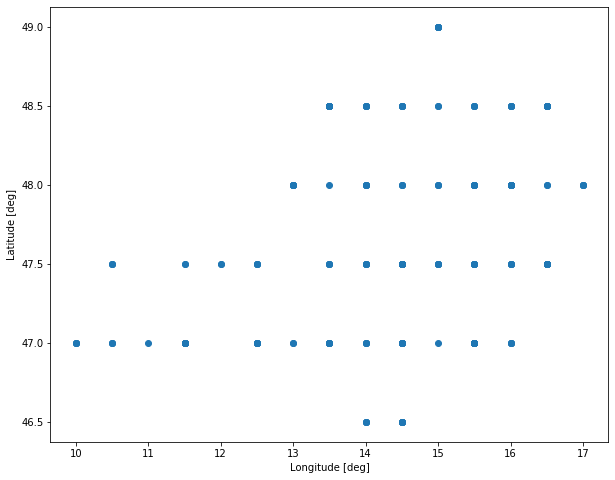

In [34]:
plt.plot(country_points['Austria_longitude'], country_points['Austria_latitude'], 'o')
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]');

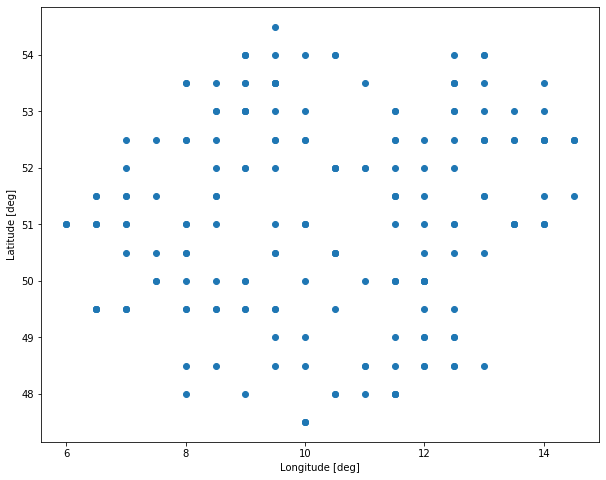

In [35]:
plt.plot(country_points['Germany_longitude'], country_points['Germany_latitude'], 'o')
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]');

# Calculate mean temperature for each country

In [36]:
country = 'Austria'
country_temperature = temperatures.sel(
        longitude=xr.DataArray(country_points['Austria_longitude'], dims='points'),
        latitude=xr.DataArray(country_points['Austria_latitude'], dims='points'))

In [37]:
country_temperature

<xarray.DataArray 'Temperature [C°]' (time: 46009, points: 200)>
array([[ -4.2307434 , -14.59317   ,  -2.26297   , ...,  -2.5500488 ,
         -1.1437683 ,  -4.4457397 ],
       [ -4.213043  , -14.806885  ,  -1.690094  , ...,  -2.4906006 ,
         -1.6597595 ,  -4.369873  ],
       [ -4.1118774 , -14.935883  ,  -1.399231  , ...,  -2.2832031 ,
         -1.5117798 ,  -4.1422424 ],
       ...,
       [ -1.6825256 ,  -7.398651  ,  -2.71698   , ...,  -2.2642517 ,
         -0.60250854,  -0.72265625],
       [ -2.0328064 ,  -7.702179  ,  -2.9193115 , ...,  -2.8813782 ,
         -1.0615845 ,  -1.2196655 ],
       [ -2.1959534 ,  -7.993042  ,  -3.278473  , ...,  -3.1216736 ,
         -1.5180969 ,  -1.7330933 ]], dtype=float32)
Coordinates:
    longitude  (points) float32 15.5 10.0 16.0 16.5 12.5 ... 11.5 14.5 14.0 17.0
    latitude   (points) float32 47.0 47.0 48.0 48.5 47.5 ... 47.0 48.5 48.0 48.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2020-04-01
  * points     (points) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199

In [38]:
def calc_country_temperature(country):
    country_temperature = temperatures.sel(
        longitude=xr.DataArray(country_points[f'{country}_longitude'], dims='points'),
        latitude=xr.DataArray(country_points[f'{country}_latitude'], dims='points')).mean(dim='points')
    return country_temperature

In [39]:
temperature_at = calc_country_temperature('Austria')

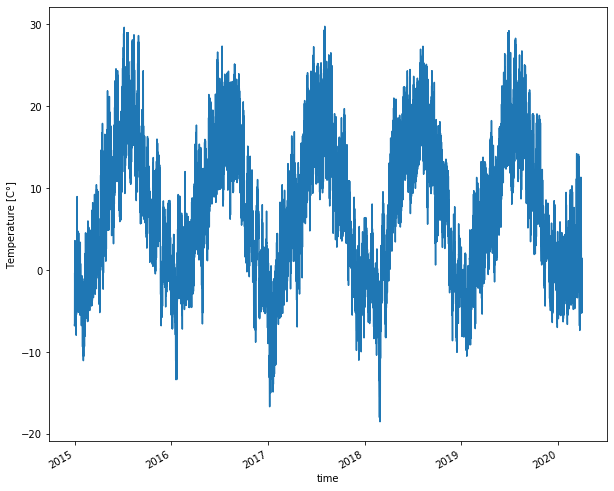

In [40]:
temperature_at.plot()

# Who likes to have it warm?

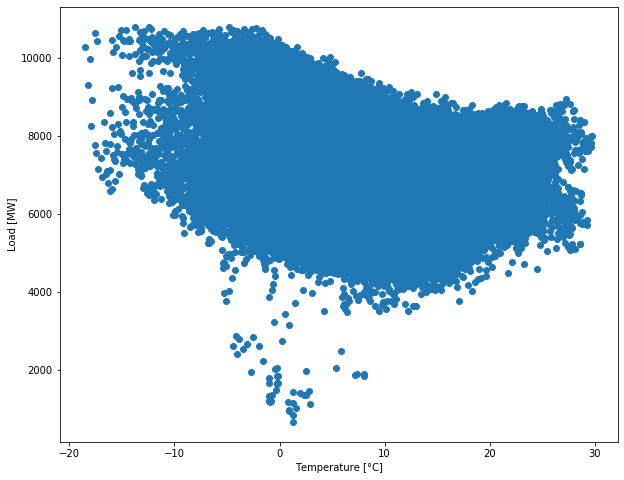

In [41]:
plt.plot(temperature_at.interp(time=power_demand.Austria.index),
         power_demand.Austria, 'o')
plt.xlabel('Temperature [°C]')
plt.ylabel('Load [MW]');

In [42]:
idcs = (power_demand.Austria.index.weekday == 2) & (power_demand.Austria.index.hour == 9)
idcs

array([False, False, False, ..., False, False, False])

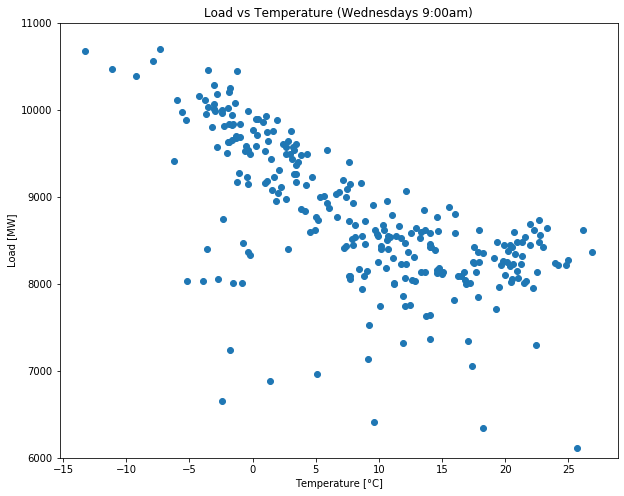

In [43]:
plt.plot(temperature_at.interp(time=power_demand.Austria.index[idcs]),
         power_demand.Austria[idcs], 'o')
plt.ylim(6_000, 11_000)
plt.xlabel('Temperature [°C]')
plt.ylabel('Load [MW]')
plt.title("Load vs Temperature (Wednesdays 9:00am)");

In [44]:
from scipy.ndimage import median_filter

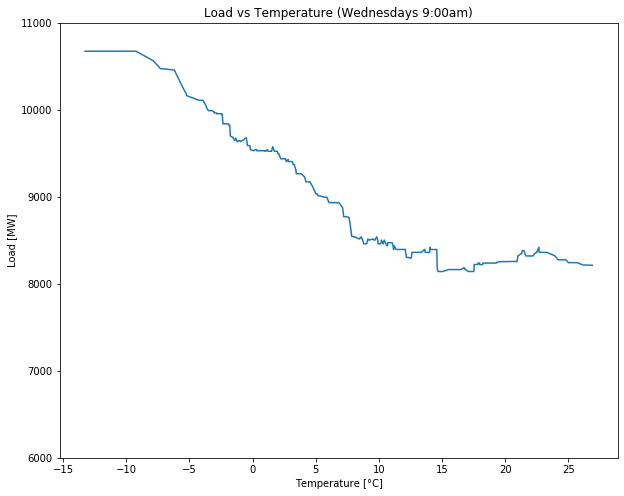

In [45]:
power_temperature = pd.DataFrame()
power_temperature['TotalLoadValue'] = power_demand.Austria[idcs]
power_temperature['Temperature'] = temperature_at.interp(time=power_demand.Austria.index[idcs])

power_temperature = power_temperature.sort_values('Temperature')

#plt.plot(power_temperature.Temperature,
#         power_temperature.TotalLoadValue, '-')

plt.plot(power_temperature.Temperature,
         median_filter(power_temperature.TotalLoadValue,
                                                 mode='nearest',
                                                 size=30),
         '-')

plt.ylim(6_000, 11_000)
plt.xlabel('Temperature [°C]')
plt.ylabel('Load [MW]')
plt.title("Load vs Temperature (Wednesdays 9:00am)");

A `median_filter()` will replace each value by the median of it's surroundings of size `size`:

In [46]:
median_filter(np.array([1., 1., 1., 1., 5., 1., 1.]), size=3)

array([1., 1., 1., 1., 1., 1., 1.])

In [47]:
median_filter(np.array([1., 1., 1., 1., 5., 5., 1.]), size=3)

array([1., 1., 1., 1., 5., 5., 1.])

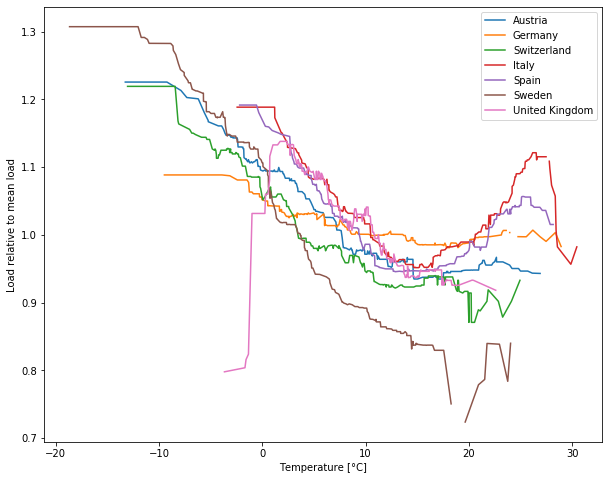

In [48]:
for country in COUNTRIES:
    power_demand_country = power_demand[country]

    country_temperature = calc_country_temperature(country)

    # select observations from Wednesdays 9:00am
    idcs = (power_demand_country.index.weekday == 2) & (power_demand_country.index.hour == 9)

    power_temperature = pd.DataFrame()

    power_temperature['TotalLoadValue'] = power_demand_country[idcs]
    power_temperature['Temperature'] = country_temperature.interp(time=power_demand_country.index[idcs])
    power_temperature = power_temperature.sort_values('Temperature')

    normalized_load = power_temperature.TotalLoadValue / power_temperature.TotalLoadValue.mean()
    normalized_load_filtered =  median_filter(normalized_load, mode='nearest', size=30)
    
    lines, = plt.plot(power_temperature.Temperature, normalized_load_filtered, '-', label=country)
    
    #if country == 'United Kingdom':
    #    plt.plot(power_temperature.Temperature, normalized_load, 'o-',
    #             linewidth=0.5, markersize=2, alpha=0.4,
    #             color=lines.get_color(),
    #             label=f"{country} (unfiltered)")


plt.xlabel('Temperature [°C]')
plt.ylabel('Load relative to mean load')
plt.legend();